In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [5]:
credit = pd.read_csv('credit_data_risk.csv')

In [6]:
credit.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [7]:

del credit['Unnamed: 0']

In [8]:
credit.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)

In [10]:
numerical_credit = credit.select_dtypes(exclude='O')

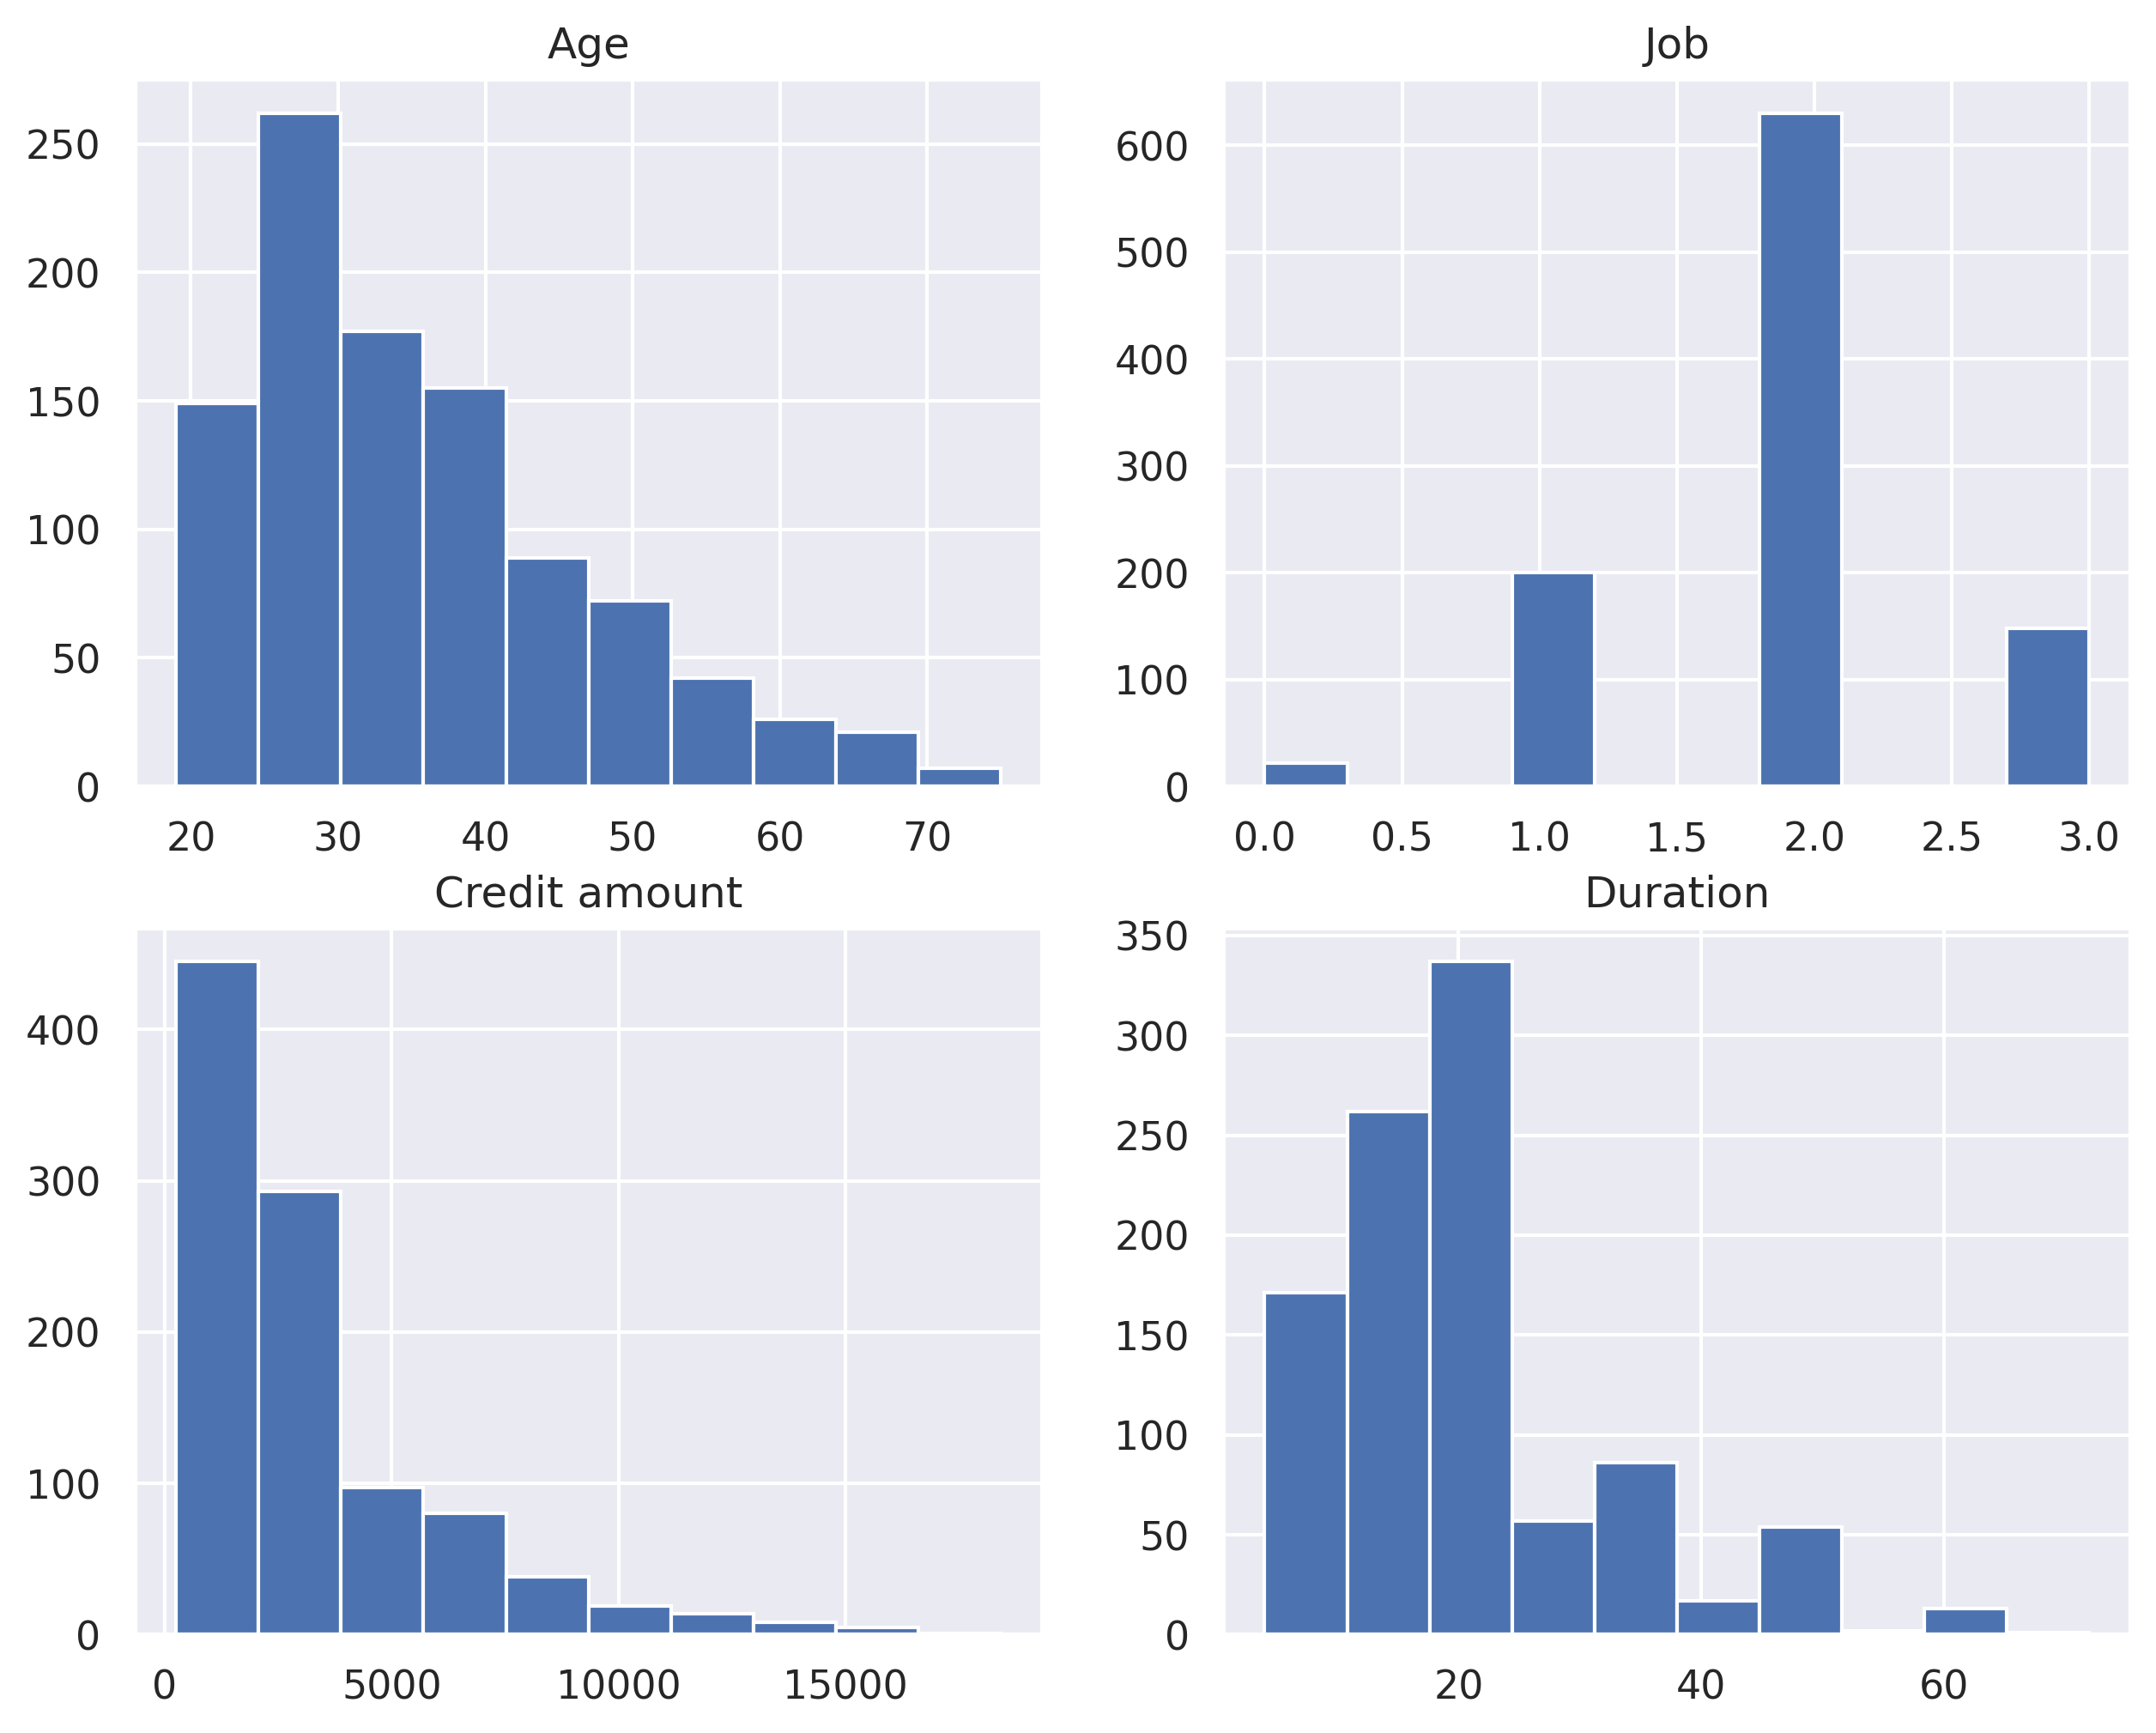

In [11]:
plt.figure(figsize=(10, 8))
k = 0
cols = numerical_credit.columns
for i, j in zip(range(len(cols)), cols):
    k +=1
    plt.subplot(2, 2, k)
    plt.hist(numerical_credit.iloc[:, i])
    plt.title(j)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [13]:
scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)

In [14]:
distance = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_credit)
    distance.append(kmeans.inertia_)

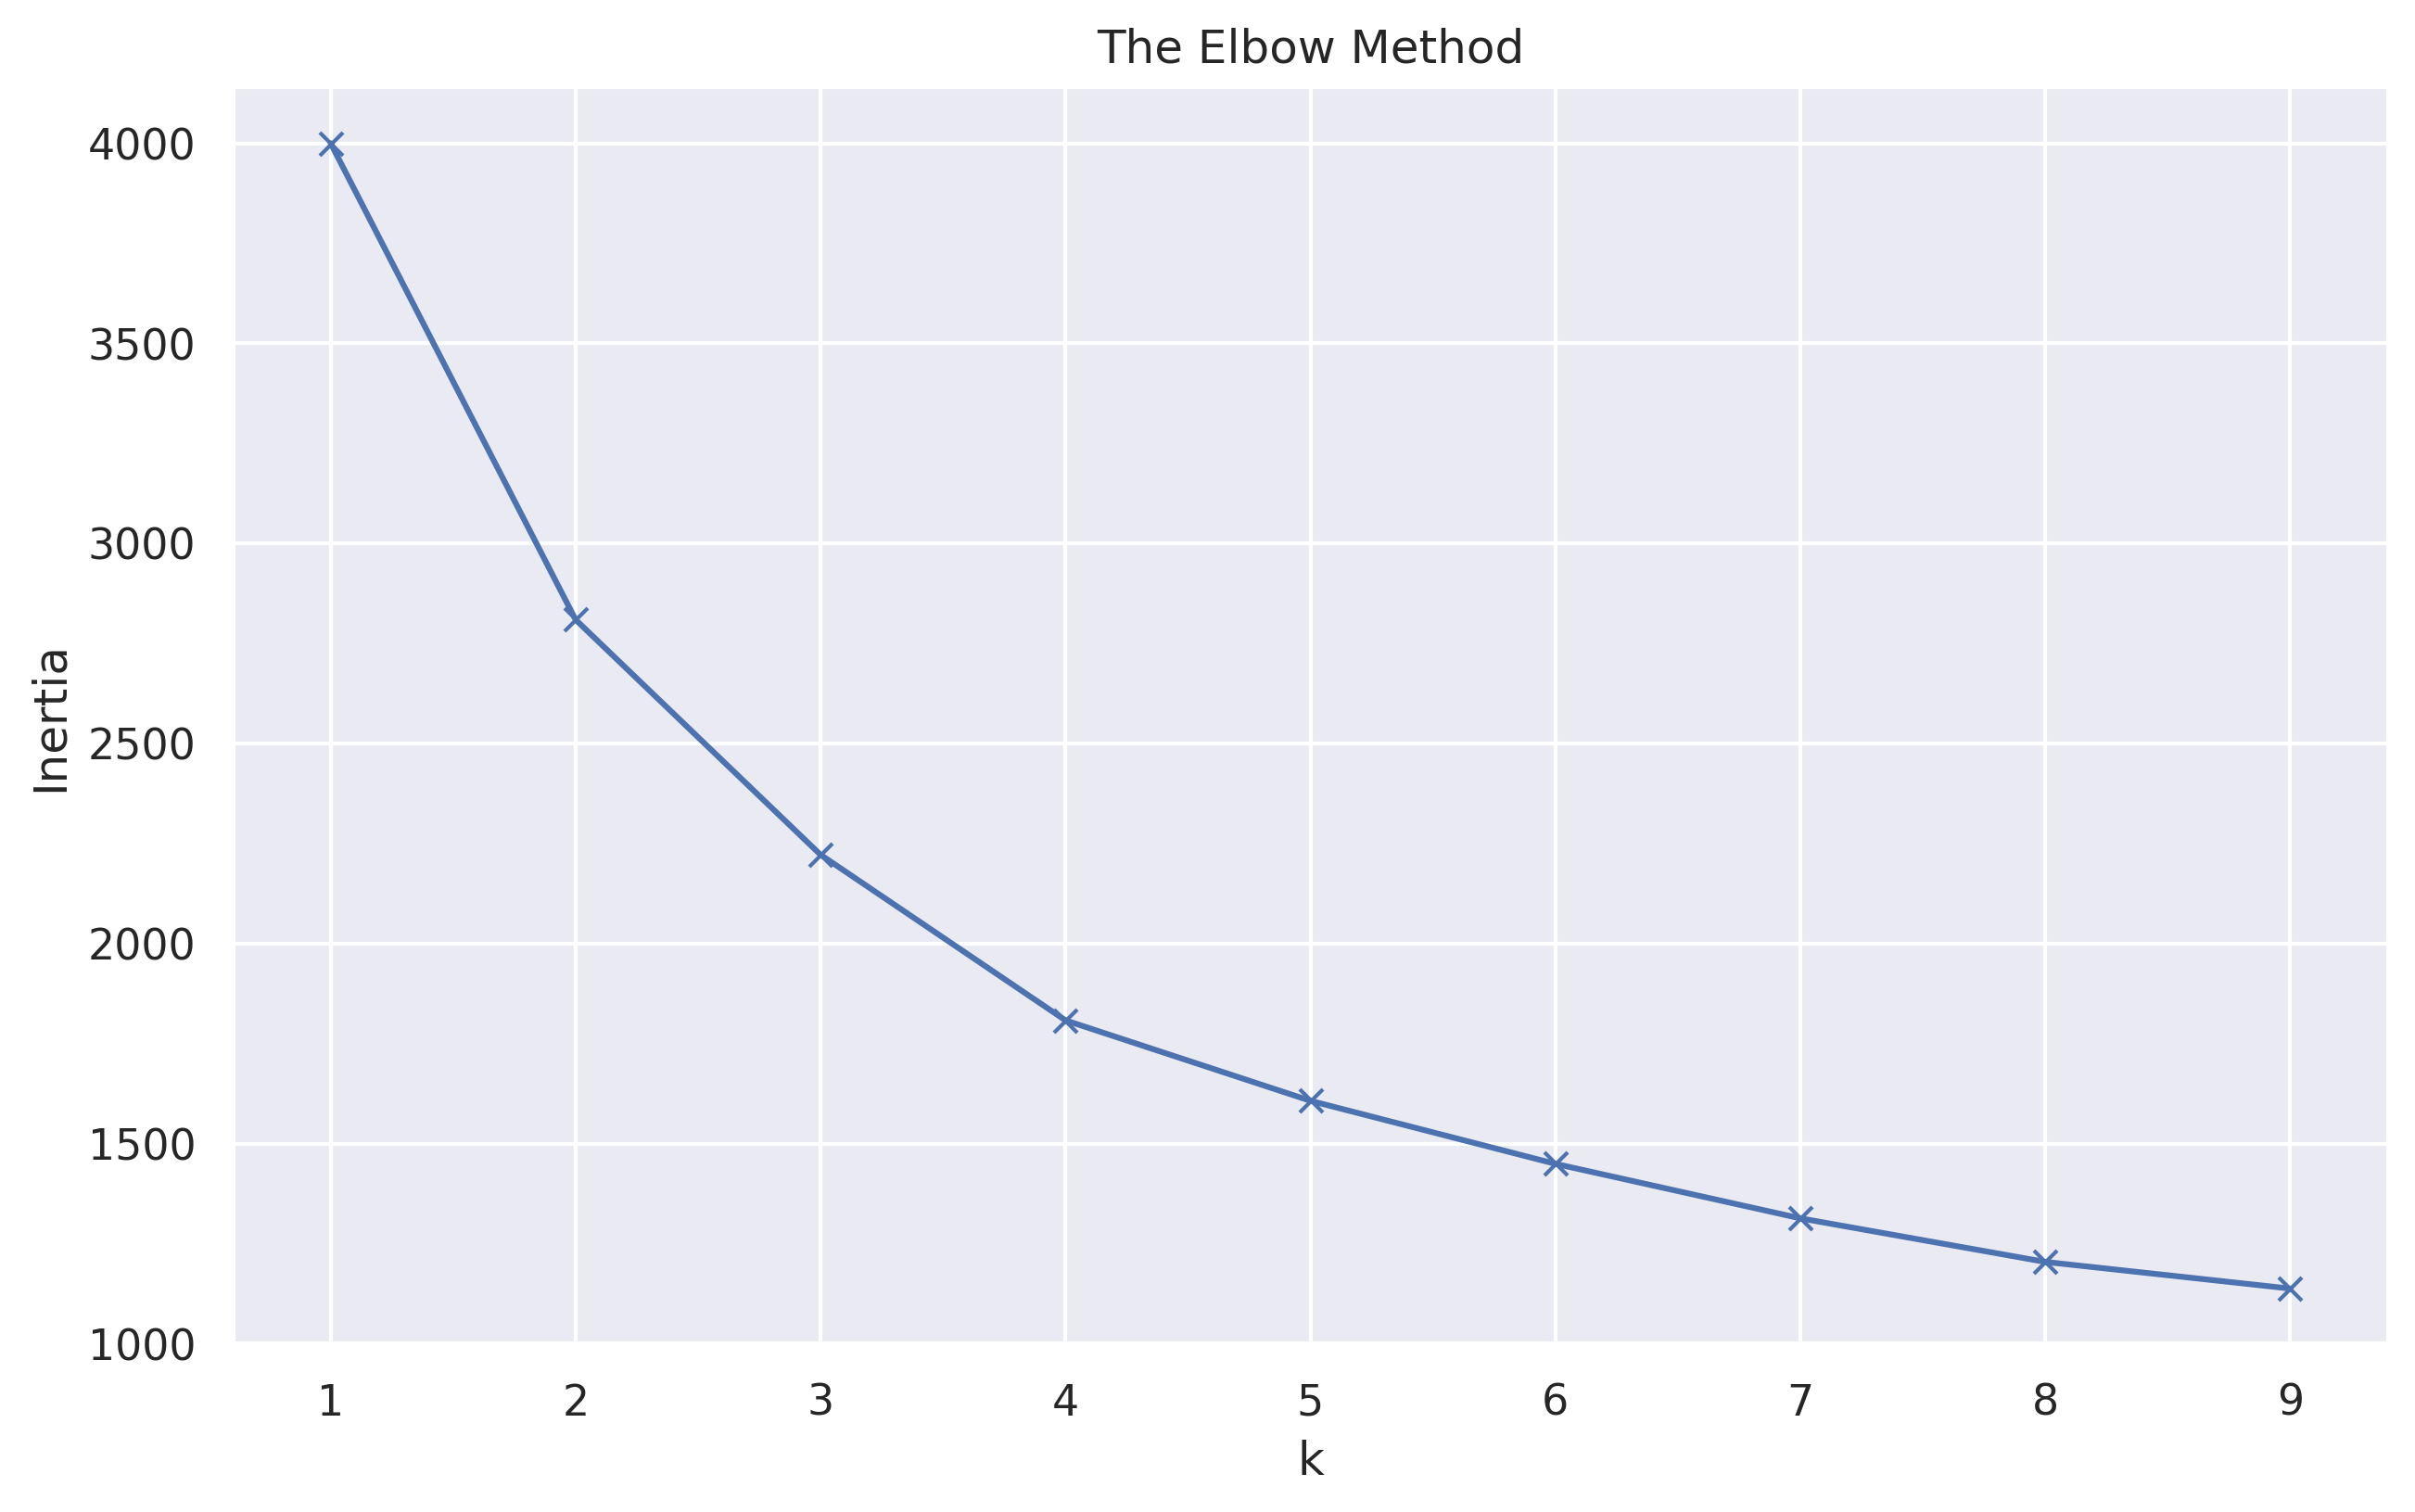

In [15]:
plt.plot(range(1, 10), distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

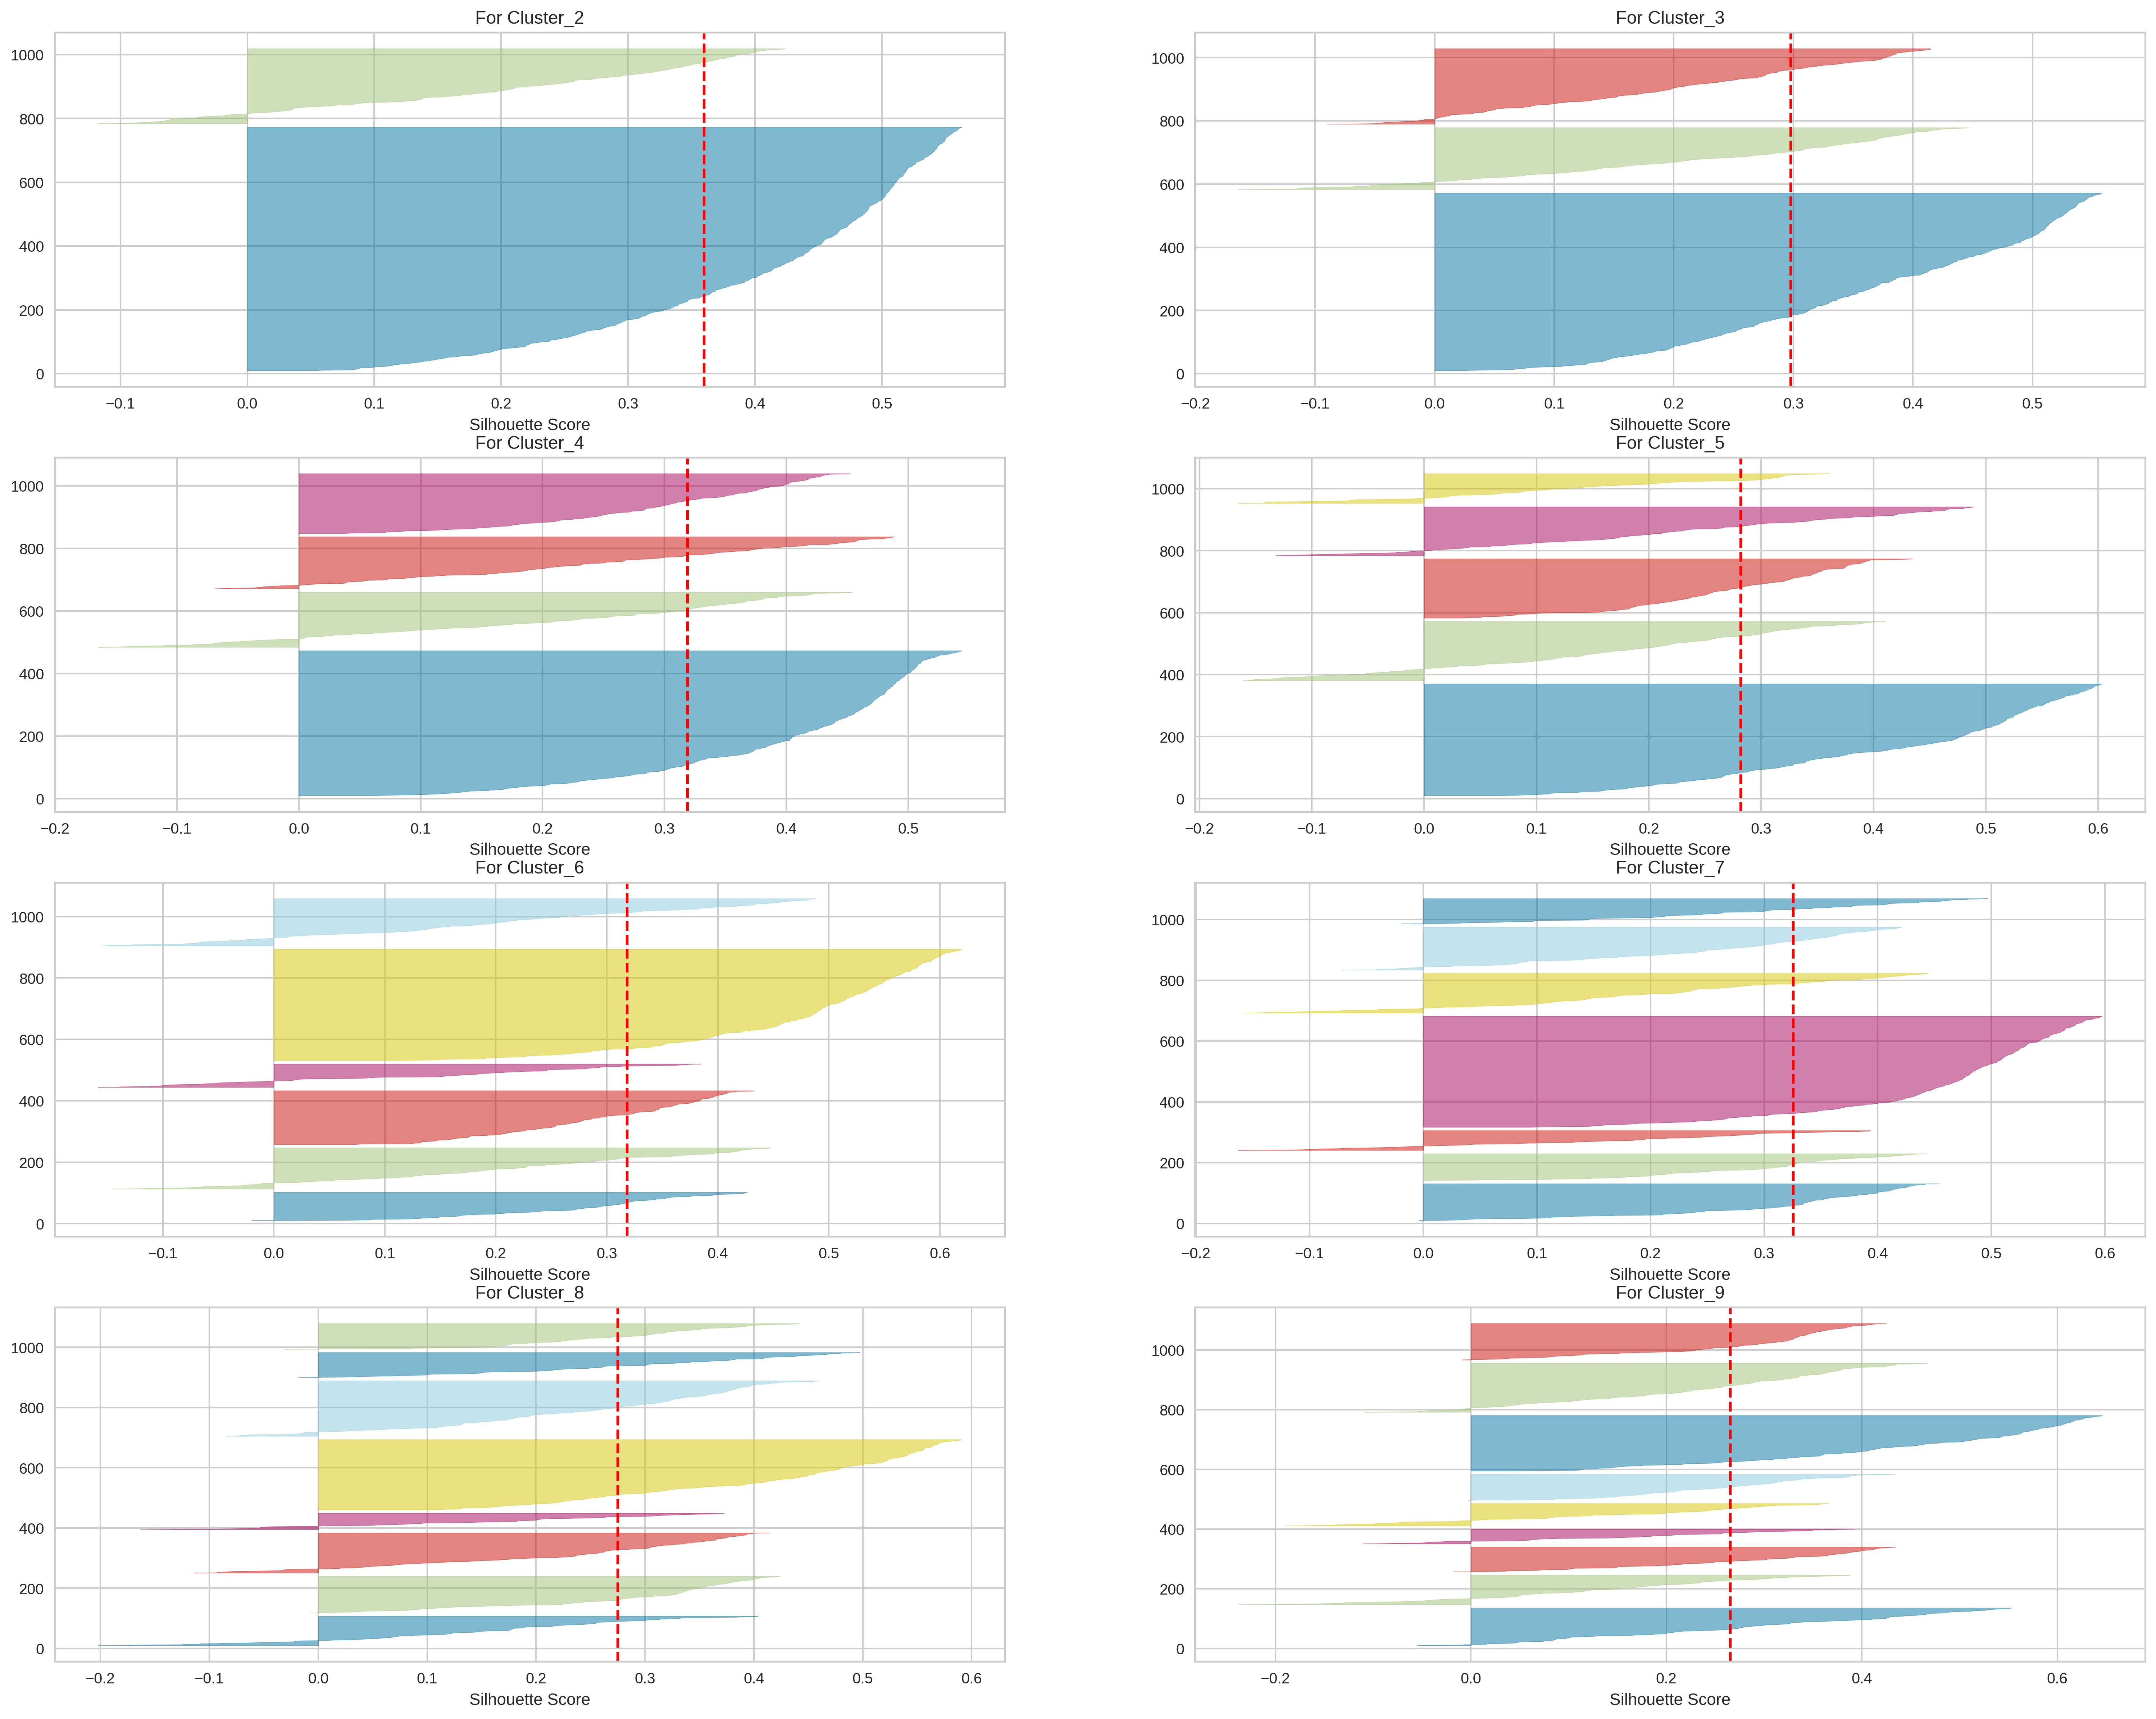

In [16]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer


fig, ax = plt.subplots(4, 2, figsize=(25, 20))
for i in range(2, 10):
    km = KMeans(n_clusters=i)
    q, r = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick',
                                      ax=ax[q - 1][r])
    visualizer.fit(scaled_credit)
    ax[q - 1][r].set_title("For Cluster_"+str(i))
    ax[q - 1][r].set_xlabel("Silhouette Score")

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(scaled_credit)

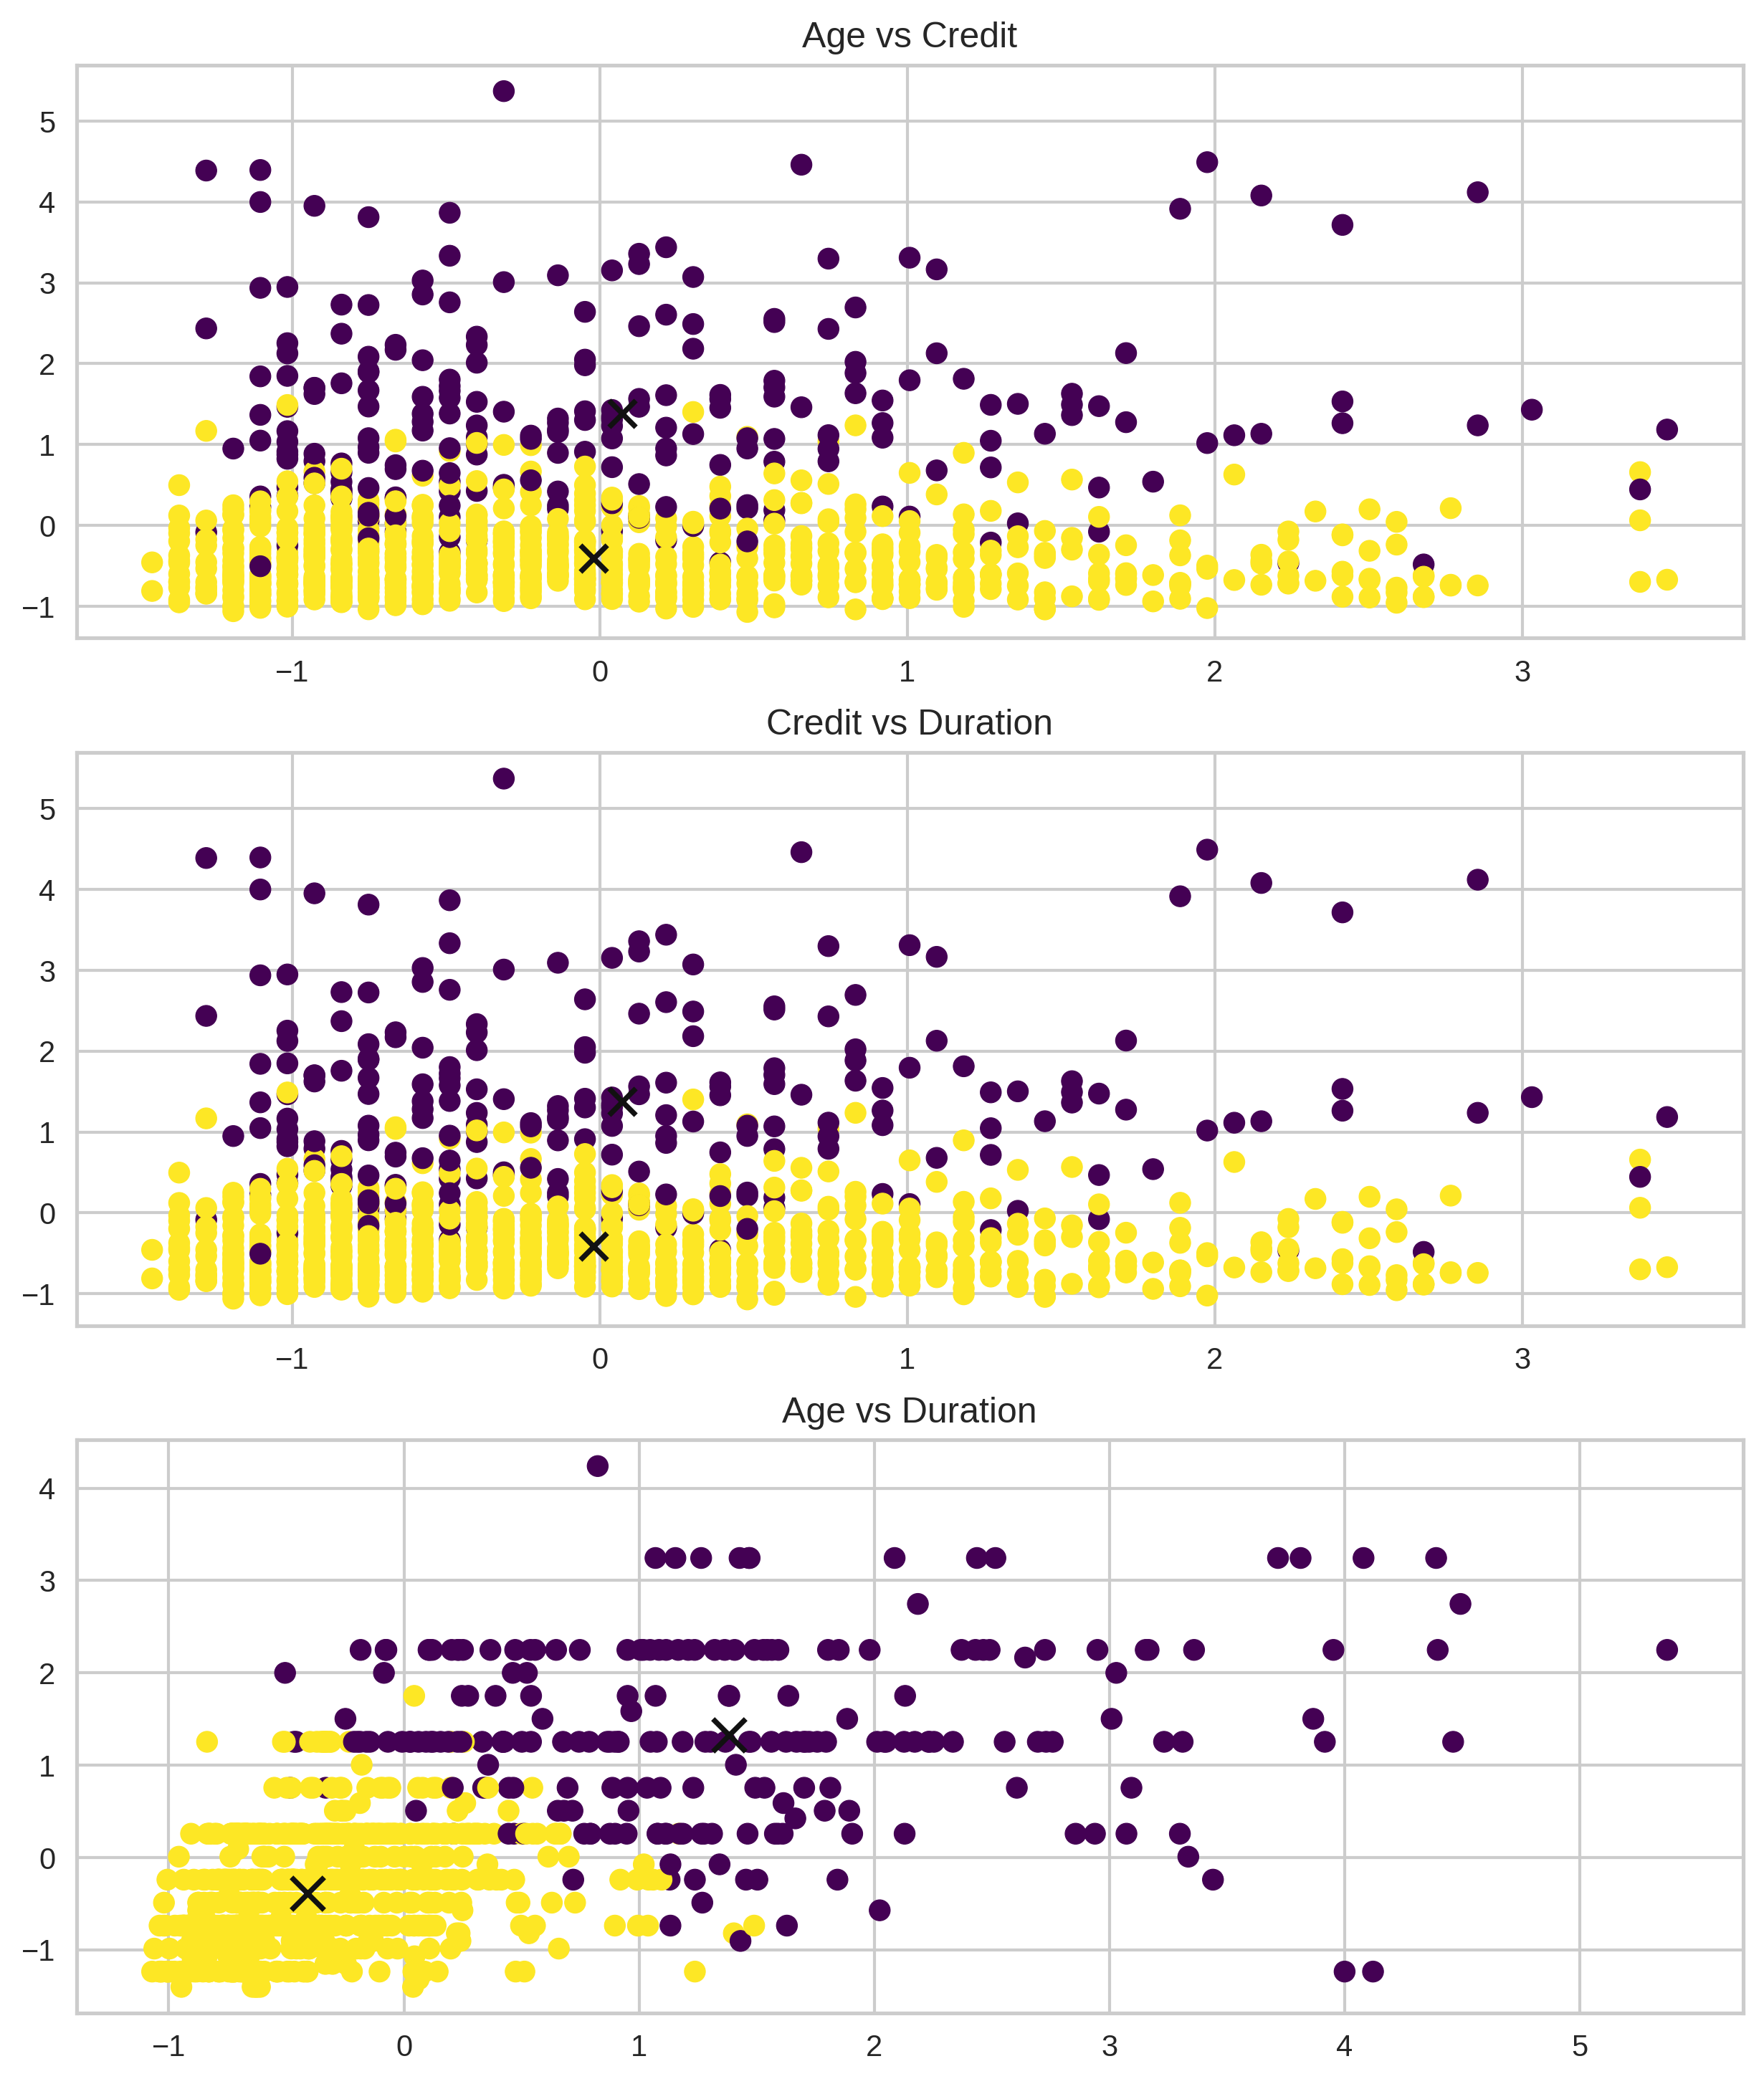

In [26]:
plt.figure(figsize=(10, 12))
plt.subplot(311)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2],
            c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 2], s = 80,
            marker= 'x', color = 'k')
plt.title('Age vs Credit')
plt.subplot(312)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2],
            c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 2], s = 80,
            marker= 'x', color = 'k')
plt.title('Credit vs Duration')
plt.subplot(313)
plt.scatter(scaled_credit[:, 2], scaled_credit[:, 3],
            c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 2],
            kmeans.cluster_centers_[:, 3], s = 120,
            marker= 'x', color = 'k')
plt.title('Age vs Duration')
plt.show()

In [27]:
clusters, counts = np.unique(kmeans.labels_, return_counts=True)

In [28]:
cluster_dict = {}
for i in range(len(clusters)):
    cluster_dict[i] = scaled_credit[np.where(kmeans.labels_==i)]

In [29]:
credit['clusters'] = pd.DataFrame(kmeans.labels_)

In [30]:
df_scaled = pd.DataFrame(scaled_credit)
df_scaled['clusters'] = credit['clusters']

In [31]:
df_scaled['Risk'] = credit['Risk']
df_scaled.columns = ['Age', 'Job', 'Credit amount',
                     'Duration', 'Clusters', 'Risk']

In [32]:
df_scaled[df_scaled.Clusters == 0]['Risk'].value_counts()

good    124
bad     105
Name: Risk, dtype: int64

In [33]:
df_scaled[df_scaled.Clusters == 1]['Risk'].value_counts()

good    576
bad     195
Name: Risk, dtype: int64

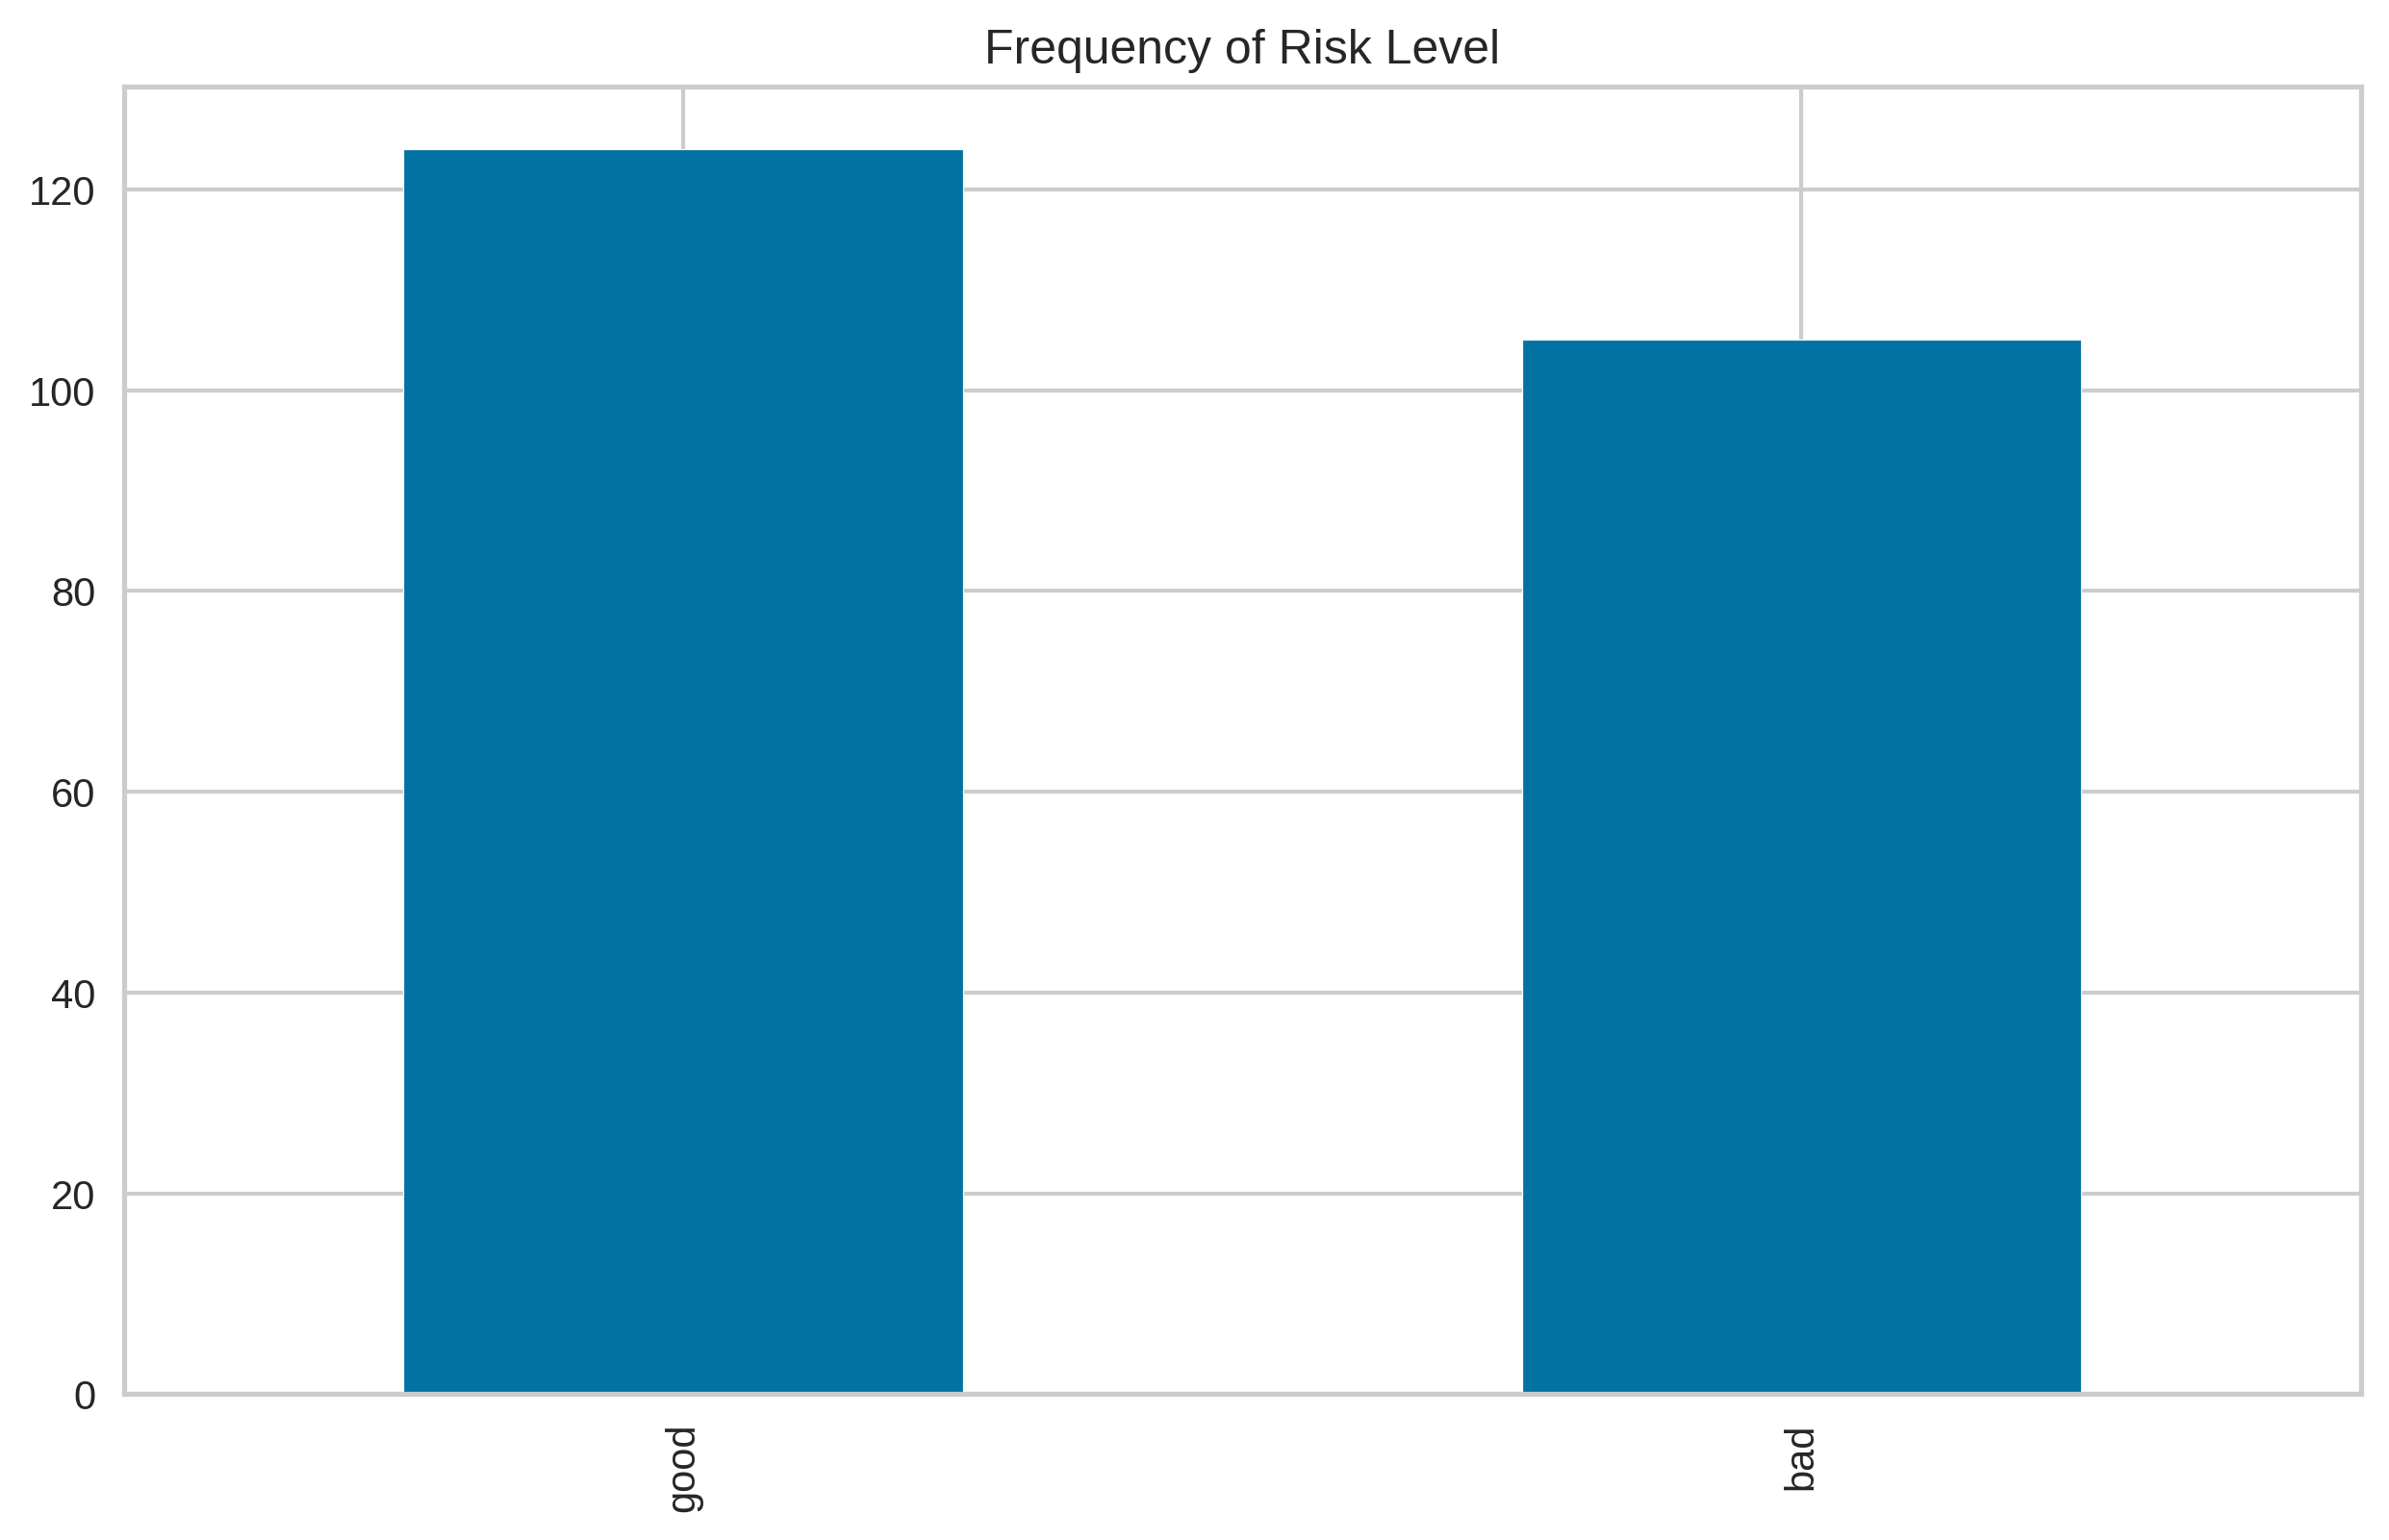

In [34]:
df_scaled[df_scaled.Clusters == 0]['Risk'].value_counts()\
                                    .plot(kind='bar',
                                    figsize=(10, 6),
                                    title="Frequency of Risk Level")
plt.show()

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
df_scaled['Risk'] = df_scaled['Risk'].replace({'good': 1, 'bad': 0})

In [37]:
X = df_scaled.drop('Risk', axis=1)
y = df_scaled.loc[:, ['Risk', 'Clusters']]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [39]:
first_cluster_train = X_train[X_train.Clusters == 0].iloc[:, :-1]
second_cluster_train = X_train[X_train.Clusters == 1].iloc[:, :-1]

# Logistic Regression for PD Estimation

In [40]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

In [41]:
X_train1 = first_cluster_train
y_train1 = y_train[y_train.Clusters == 0]['Risk']
smote = SMOTEENN(random_state = 2)
X_train1, y_train1 = smote.fit_resample(X_train1, y_train1.ravel())
logit = sm.Logit(y_train1, X_train1)
logit_fit1 = logit.fit()
print(logit_fit1.summary())

Optimization terminated successfully.
         Current function value: 0.575443
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   49
Model:                          Logit   Df Residuals:                       45
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Sep 2022   Pseudo R-squ.:                  0.1490
Time:                        15:29:22   Log-Likelihood:                -28.197
converged:                       True   LL-Null:                       -33.133
Covariance Type:            nonrobust   LLR p-value:                   0.01968
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age              -0.1496      0.331     -0.452      0.651      -0.798       0.499
Job               1.

In [42]:
first_cluster_test = X_test[X_test.Clusters == 0].iloc[:, :-1]
second_cluster_test = X_test[X_test.Clusters == 1].iloc[:, :-1]

In [43]:
X_test1 = first_cluster_test
y_test1 = y_test[y_test.Clusters == 0]['Risk']
pred_prob1 = logit_fit1.predict(X_test1)

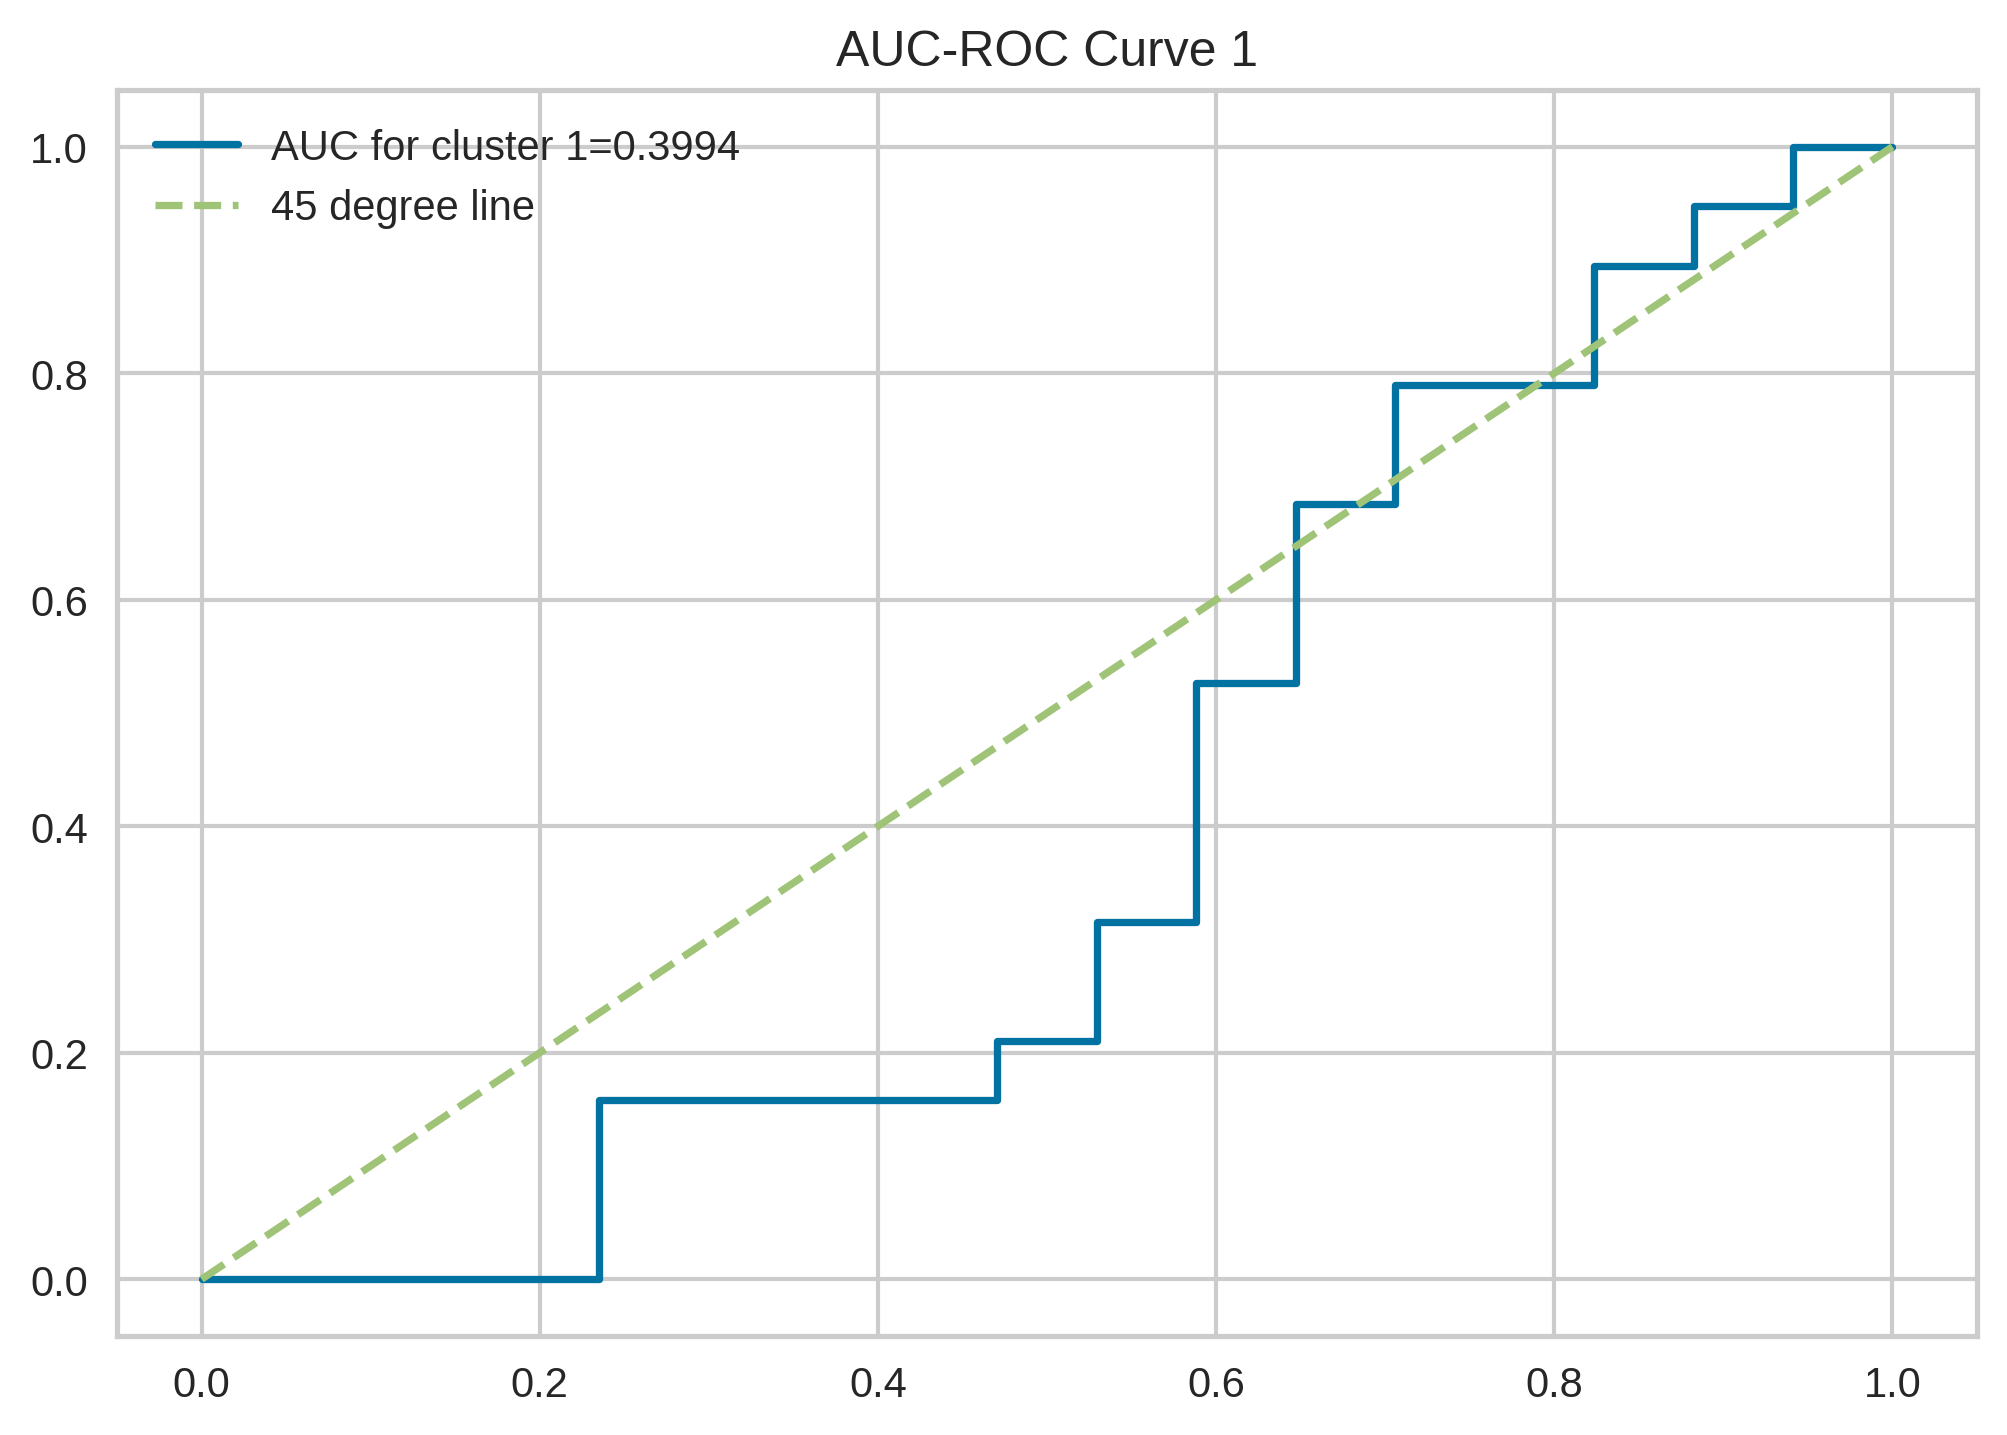

In [44]:
false_pos, true_pos, _ = roc_curve(y_test1.values,  pred_prob1)
auc = roc_auc_score(y_test1, pred_prob1)
plt.plot(false_pos,true_pos, label="AUC for cluster 1={:.4f} "
         .format(auc))
plt.plot([0, 1], [0, 1], linestyle = '--', label='45 degree line')
plt.legend(loc='best')
plt.title('AUC-ROC Curve 1')
plt.show()

Optimization terminated successfully.
         Current function value: 0.603080
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  607
Model:                          Logit   Df Residuals:                      603
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Sep 2022   Pseudo R-squ.:                -0.06818
Time:                        15:30:50   Log-Likelihood:                -366.07
converged:                       True   LL-Null:                       -342.70
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               0.3933      0.098      4.023      0.000       0.202       0.585
Job              -0.

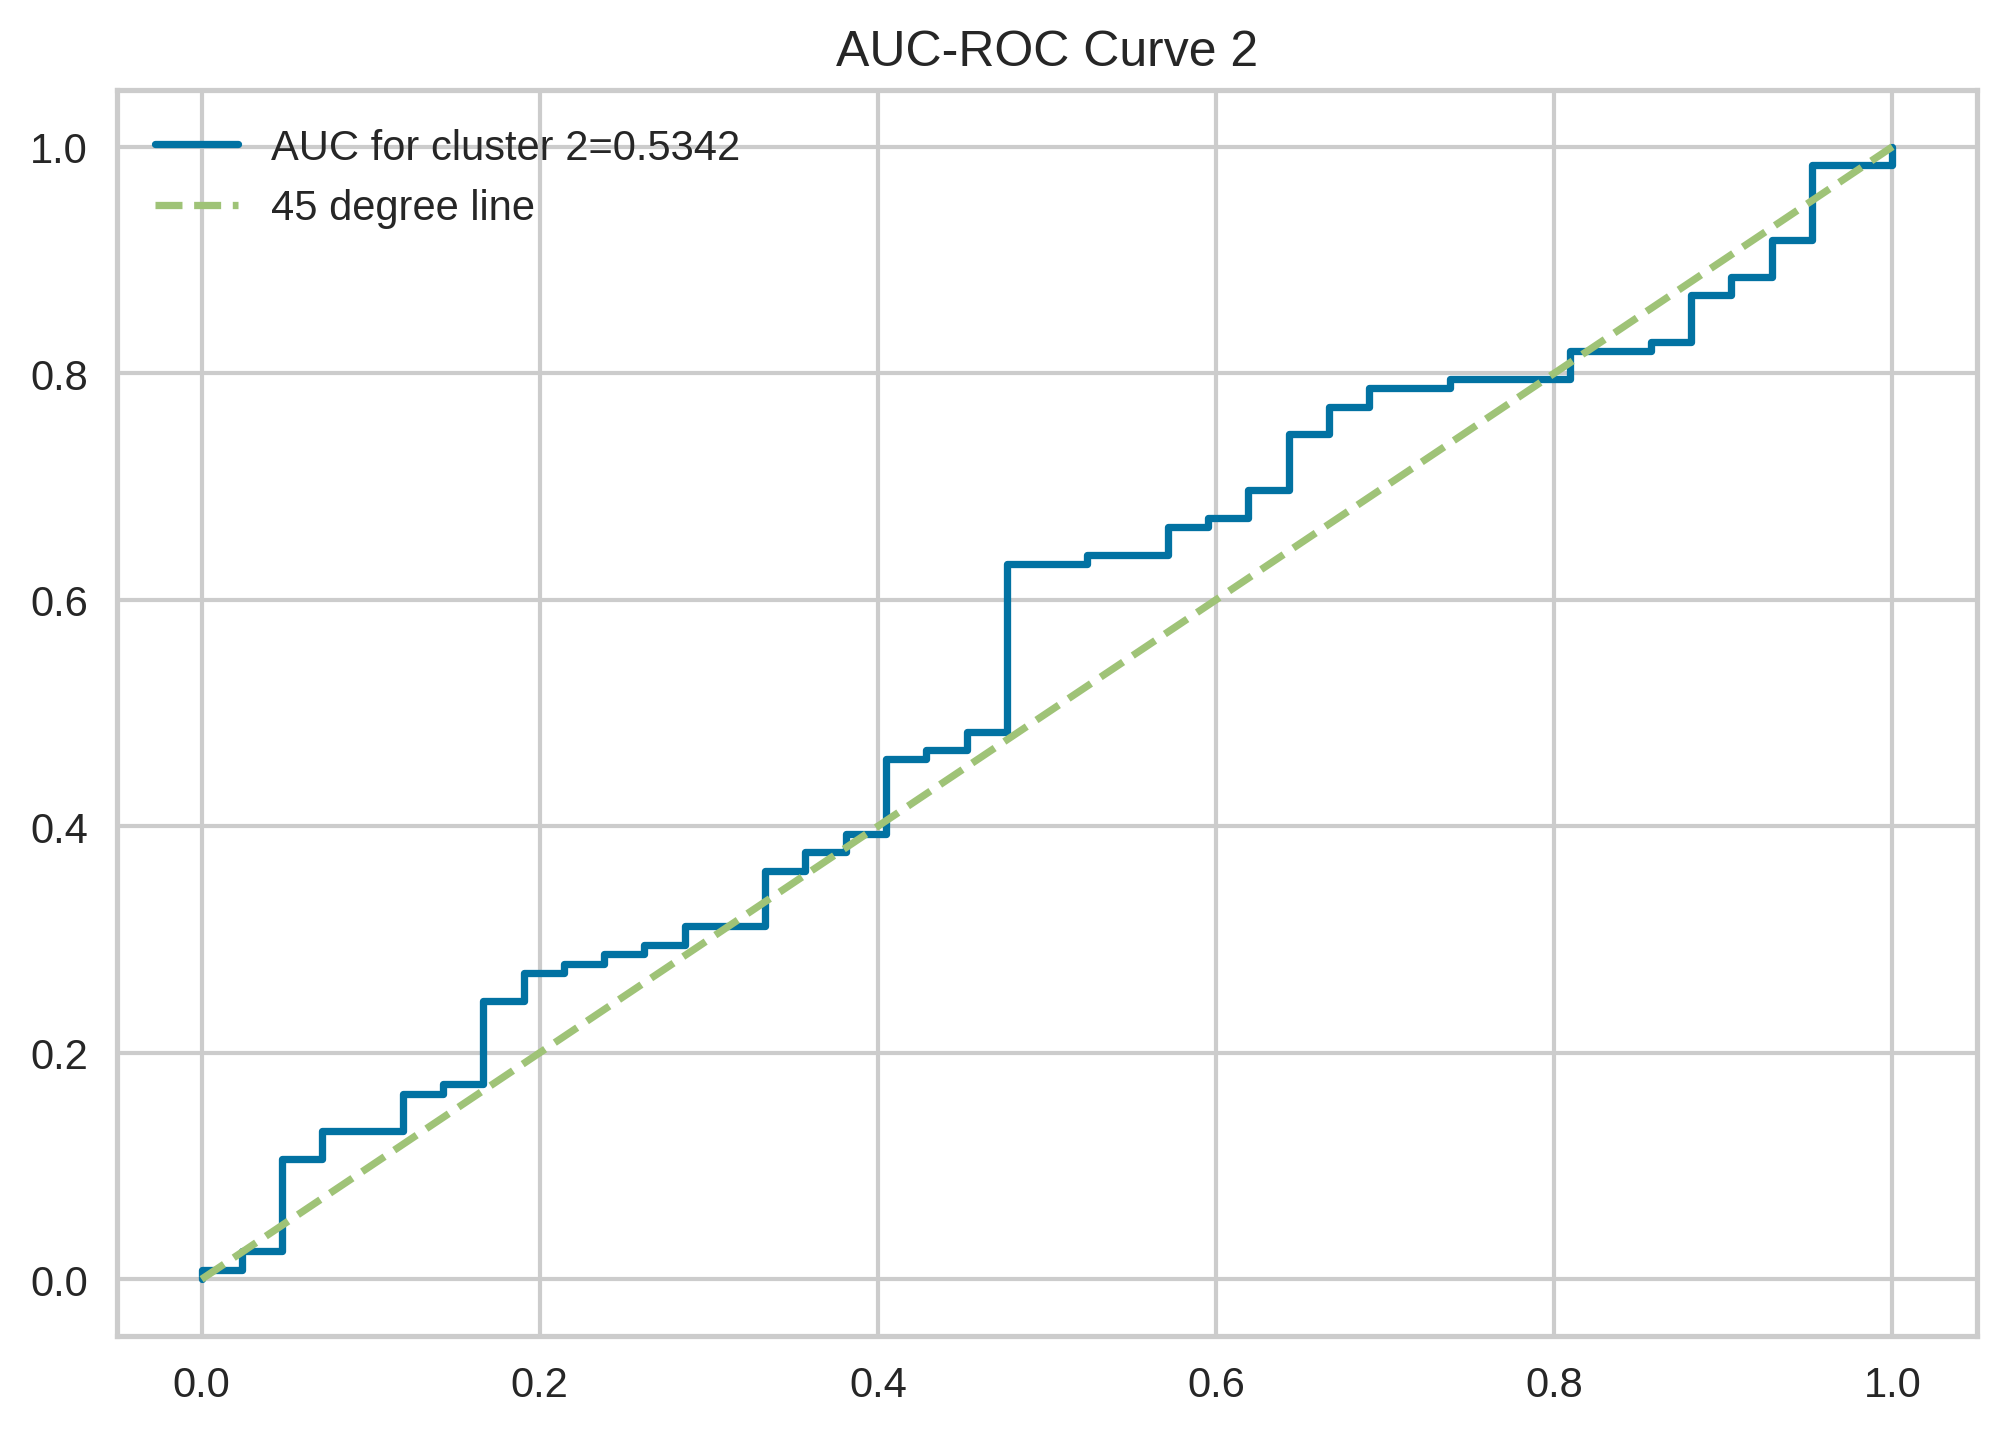

In [45]:
X_train2 = second_cluster_train
y_train2 = y_train[y_train.Clusters == 1]['Risk']
logit = sm.Logit(y_train2, X_train2)
logit_fit2 = logit.fit()
print(logit_fit2.summary())
X_test2 = second_cluster_test
y_test2 = y_test[y_test.Clusters == 1]['Risk']
pred_prob2 = logit_fit2.predict(X_test2)
false_pos, true_pos, _ = roc_curve(y_test2.values,  pred_prob2)
auc = roc_auc_score(y_test2, pred_prob2)
plt.plot(false_pos,true_pos,label="AUC for cluster 2={:.4f} "
         .format(auc))
plt.plot([0, 1], [0, 1], linestyle = '--', label='45 degree line')
plt.legend(loc='best')
plt.title('AUC-ROC Curve 2')
plt.show()

# Bayesian Approach for PD Estimation

In [47]:
pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 3.8 MB/s 
     |████████████████████████████████| 1.8 MB 42.5 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=20b41d05358f5e7058dad6d371a36223e95dc2acf8ba9bf782bdf2c13dbe5d60
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [49]:
import pymc3 as pm
import arviz as az

with pm.Model() as logistic_model1:
    beta_age = pm.Normal('coeff_age', mu=0, sd=10)
    beta_job = pm.Normal('coeff_job', mu=0, sd=10)
    beta_credit = pm.Normal('coeff_credit_amount', mu=0, sd=10)
    beta_dur = pm.Normal('coeff_duration', mu=0, sd=10)
    p = pm.Deterministic('p', pm.math.sigmoid(beta_age * 
                              X_train1['Age'] + beta_job *
                              X_train1['Job'] + beta_credit *
                              X_train1['Credit amount'] + beta_dur *
                              X_train1['Duration']))
with logistic_model1:
    observed = pm.Bernoulli("risk", p, observed=y_train1)
    map_estimate = pm.find_MAP()

In [50]:
param_list = ['coeff_age', 'coeff_job',
              'coeff_credit_amount', 'coeff_duration']
params = {}
for i in param_list:
    params[i] = [np.round(map_estimate[i], 6)] 
    
bayesian_params = pd.DataFrame.from_dict(params)    
print('The result of Bayesian estimation:\n {}'.format(bayesian_params))

The result of Bayesian estimation:
    coeff_age  coeff_job  coeff_credit_amount  coeff_duration
0  -0.148026   1.080937            -0.980716        0.918227


In [51]:
with pm.Model() as logistic_model2:
    beta_age = pm.Normal('coeff_age', mu=0, sd=10)
    beta_job = pm.Normal('coeff_job', mu=0, sd=10)
    beta_credit = pm.Normal('coeff_credit_amount', mu=0, sd=10)
    beta_dur = pm.Normal('coeff_duration', mu=0, sd=10)
    p = pm.Deterministic('p', pm.math.sigmoid(beta_age *
                              second_cluster_train['Age'] + 
                              beta_job * second_cluster_train['Job'] + 
                              beta_credit * second_cluster_train['Credit amount'] + 
                              beta_dur * second_cluster_train['Duration']))
with logistic_model2:
    observed = pm.Bernoulli("risk", p,
                            observed=y_train[y_train.Clusters == 1]
                            ['Risk'])
    map_estimate = pm.find_MAP()

In [52]:
param_list = [ 'coeff_age', 'coeff_job',
              'coeff_credit_amount', 'coeff_duration']
params = {}
for i in param_list:
    params[i] = [np.round(map_estimate[i], 6)]
    
bayesian_params = pd.DataFrame.from_dict(params)    
print('The result of Bayesian estimation:\n {}'.format(bayesian_params))

The result of Bayesian estimation:
    coeff_age  coeff_job  coeff_credit_amount  coeff_duration
0    0.39324  -0.060987               -0.674       -0.801389
